In [27]:
import otagrum

import openturns as ot

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

In [39]:
bn = gum.BayesNet.fastPrototype('A;B;C;D;E;A->B->C->D;E->A->C<-E')
bn

(gum::BayesNet<double>@0x560eaaa1a550) BN{nodes: 5, arcs: 6, domainSize: 32, parameters: 30, compression ratio: 6% }

In [40]:
ndag=otagrum.NamedDAG(bn)
order=ndag.getTopologicalOrder()

In [41]:
jointDistributions=[]
for i in range(order.getSize()):
    d = 1 + ndag.getParents(i).getSize()
    #jointDistributions.append(ot.Dirichlet([(1.0+k)/(d+1) for k in range(d+1)]).getCopula())
    R = ot.CorrelationMatrix(d)
    for i in range(d):
        for j in range(i):
            R[i, j] = 0.8
    #jointDistributions.append(ot.Student(5.0, [0.0]*d, [1.0]*d, R).getCopula())
    jointDistributions.append(ot.Normal([0.0]*d, [1.0]*d, R).getCopula())
    

In [42]:
copula = otagrum.ContinuousBayesianNetwork(ndag, jointDistributions)
sample = copula.getSample(100000)

In [43]:
sample.exportToCSVFile("gaussian_copula_sample_2.csv", ',')

In [44]:
learner=otagrum.ContinuousPC(sample, 5, 0.1)
g=learner.inferSkeleton()
pdag=learner.inferPDAG(g)
gnb.sideBySide(bn,gnb.getDot(g.toDot()),gnb.getDot(learner.learnDAG().toDot()))

G <!-- A --> A A <!-- B --> B B <!-- A->B --> A->B <!-- C --> C C <!-- A->C --> A->C <!-- B->C --> B->C <!-- D --> D D <!-- C->D --> C->D <!-- E --> E E <!-- E->A --> E->A <!-- E->C --> E->C,no_name <!-- 0 --> 0 0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 <!-- 2 --> 2 2 <!-- 0->2 --> 0->2 <!-- 4 --> 4 4 <!-- 0->4 --> 0->4 <!-- 1->2 --> 1->2 <!-- 3 --> 3 3 <!-- 1->3 --> 1->3 <!-- 2->3 --> 2->3 <!-- 2->4 --> 2->4 <!-- 3->4 --> 3->4


In [45]:
pdag

(gum::MixedGraph@0x560eaa2d31a0) {0,1,2,3,4} , {3->4,0->4,1->2,4->2} , {0--1,1--3,2--3,0--2}

In [47]:
for s in learner.getTrace():
    print(s)

000 :        A-D|B,C                   p=0.139533    ttest=1.47753
001 :        B-E|D,A                   p=0.157085    ttest=1.41494


In [49]:
test=otagrum.ContinuousTTest(sample)
print(test.isIndep(0,3,[2]))
print(test.isIndep(1,3,[2]))

(5.396842798659421, 6.782376269614212e-08, False)
(4.59985549965638, 4.22784109245231e-06, False)


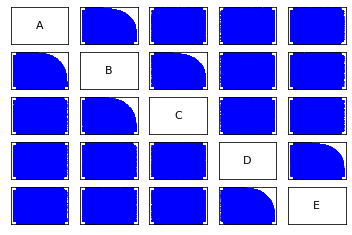

In [7]:
ot.Show(ot.Pairs(sample))

In [8]:
print(sample.computeSpearmanCorrelation())

5x5
[[  1           -0.24656      0.0723976    1.31498e-06 -0.0051306   ]
 [ -0.24656      1           -0.254731    -0.00578302   0.00655624  ]
 [  0.0723976   -0.254731     1           -0.000141581 -0.0100718   ]
 [  1.31498e-06 -0.00578302  -0.000141581  1           -0.242756    ]
 [ -0.0051306    0.00655624  -0.0100718   -0.242756     1           ]]


In [9]:
print("\n".join([str(d) for d in jointDistributions]))

IndependentCopula(dimension = 1)
class=SklarCopula name=SklarCopula dimension=2 distribution=class=Dirichlet name=Dirichlet dimension=2 theta=class=Point name=Unnamed dimension=3 values=[0.333333,0.666667,1]
class=SklarCopula name=SklarCopula dimension=2 distribution=class=Dirichlet name=Dirichlet dimension=2 theta=class=Point name=Unnamed dimension=3 values=[0.333333,0.666667,1]
IndependentCopula(dimension = 1)
class=SklarCopula name=SklarCopula dimension=2 distribution=class=Dirichlet name=Dirichlet dimension=2 theta=class=Point name=Unnamed dimension=3 values=[0.333333,0.666667,1]


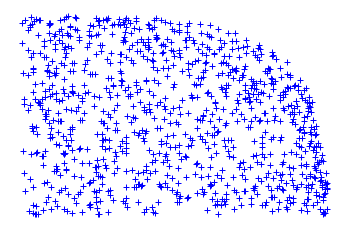

In [10]:
student = jointDistributions[1]
ot.Show(ot.Cloud(student.getCopula().getSample(1000)))

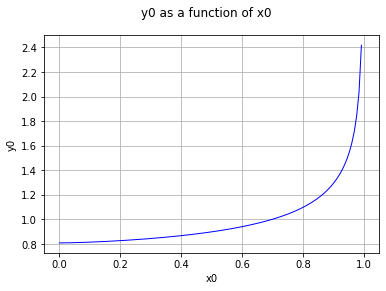

In [11]:
a=0.2
def f(x):
    return [student.getCopula().computeConditionalPDF(x[0], [a])]
fot = ot.PythonFunction(1,1,f)
ot.Show(fot.draw(0.0+1e-6,1.0-1e-6))

In [11]:
sample1=sample[0:5000]
bw=ot.KernelSmoothing().computeSilvermanBandwidth(sample1.getMarginal([0,1,2]))
print(bw)
j01=ot.KernelSmoothing().build(sample1.getMarginal([0,1]), bw[0:2])
j12=ot.KernelSmoothing().build(sample1.getMarginal([1,2]), bw[1:])
j012=ot.KernelSmoothing().build(sample1.getMarginal([0,1,2]), bw)
j1=ot.KernelSmoothing().build(sample1.getMarginal([1]), bw[0:1])

[0.110236,0.111736,0.11116]


In [12]:
s01=j01.computePDF(sample.getMarginal([0,1]))
s12=j12.computePDF(sample.getMarginal([1,2]))
s012=j012.computePDF(sample.getMarginal([0,1,2]))
s1=j1.computePDF(sample.getMarginal([1]))

In [13]:
ratio=[[s01[i,0]*s12[i,0]/s012[i,0]/s1[i,0]] for i in range(s01.getSize())]

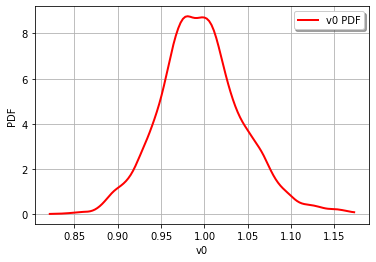

In [14]:
ot.Show(ot.KernelSmoothing().build(ratio).drawPDF())

[0.110236,0.111736,0.11116]


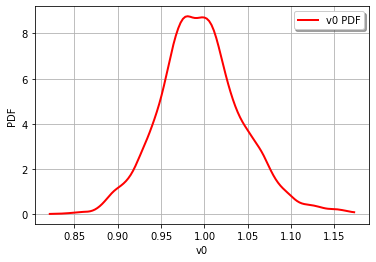

In [15]:
bw=ot.KernelSmoothing().computeSilvermanBandwidth(sample1.getMarginal([0,1,2]))
print(bw)
j02=ot.KernelSmoothing().build(sample1.getMarginal([0,1]), [bw[0]]+[bw[2]])
j12=ot.KernelSmoothing().build(sample1.getMarginal([1,2]), bw[1:])
j012=ot.KernelSmoothing().build(sample1.getMarginal([0,1,2]), bw)
j2=ot.KernelSmoothing().build(sample1.getMarginal([1]), bw[2:])

s02=j01.computePDF(sample.getMarginal([0,2]))
s12=j12.computePDF(sample.getMarginal([1,2]))
s012=j012.computePDF(sample.getMarginal([0,1,2]))
s2=j1.computePDF(sample.getMarginal([2]))

ratio=[[s01[i,0]*s12[i,0]/s012[i,0]/s1[i,0]] for i in range(s01.getSize())]

ot.Show(ot.KernelSmoothing().build(ratio).drawPDF())

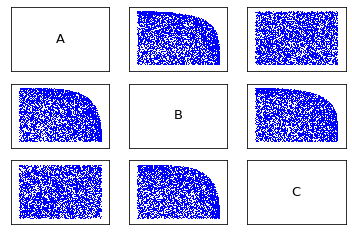

In [16]:
pairs=ot.Pairs(sample1.getMarginal([0,1,2]))
pairs.setPointStyle("dot")
ot.Show(pairs)

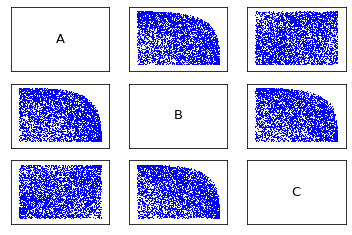

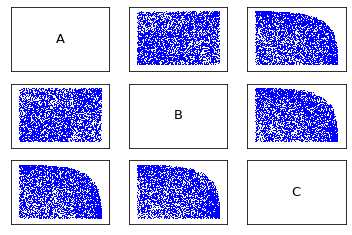

In [17]:
def buildSam(s):
    bn = gum.BayesNet.fastPrototype(s)
    ndag=otagrum.NamedDAG(bn)
    order=ndag.getTopologicalOrder()

    jointDistributions=[]
    for i in range(order.getSize()):
        d = 1 + ndag.getParents(i).getSize()
        jointDistributions.append(ot.Dirichlet([(1.0+k+i)/(d+1) for k in range(d+1)]).getCopula())
    
    copula = otagrum.ContinuousBayesianNetwork(ndag, jointDistributions)
    return copula.getSample(5000)

sample1=buildSam('A->B->C')
sample2=buildSam('A->C->B').getMarginal([0,2,1])

pairs1=ot.Pairs(sample1)
pairs1.setPointStyle("dot")
ot.Show(pairs1)

pairs2=ot.Pairs(sample2)
pairs2.setPointStyle("dot")
ot.Show(pairs2)

In [18]:
def indep(x,y,z=[]):
    print("==")
    print(otagrum.ContinuousTTest(sample1).isIndep(x,y,z))
    print(otagrum.ContinuousTTest(sample2).isIndep(x,y,z))

In [19]:
indep(1,2,[0])
indep(0,1,[2])

==
(0.21421095073701366, 0.8303825568296407, True)
(0.21421095073701366, 0.8303825568296407, True)
==
(0.21421095073701366, 0.8303825568296407, True)
(0.21421095073701366, 0.8303825568296407, True)


In [22]:
c01=ot.BernsteinCopulaFactory().build(sample1.getMarginal([0,1]))
c02=ot.BernsteinCopulaFactory().build(sample1.getMarginal([0,2]))
c12=ot.BernsteinCopulaFactory().build(sample1.getMarginal([1,2]))


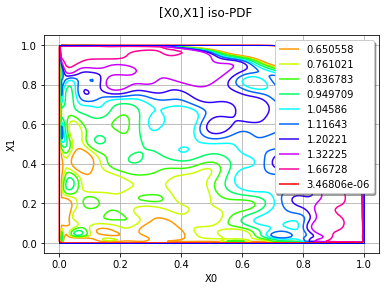

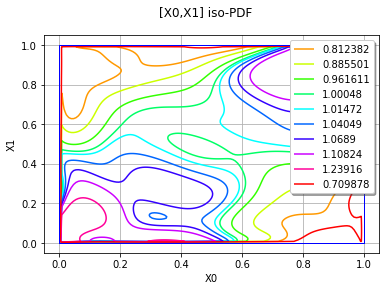

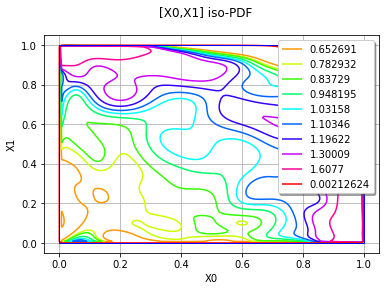

In [23]:
ot.Show(c01.drawPDF())
ot.Show(c02.drawPDF())
ot.Show(c12.drawPDF())